In [1]:
!pip install dm-haiku
!pip install optax

import dataclasses
import haiku as hk
import jax
import jax.numpy as jnp
import math
import matplotlib.pyplot as plt
import numpy as np
import optax

from sklearn import decomposition
from sklearn import preprocessing
from sklearn import utils
import tensorflow_datasets as tfds
import tqdm
from typing import Tuple

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Number of samples for shadow model evaluation.
num_samples_mnist_prediction_eval=1000 #@param {type:"integer"}

# Number of samples in fixed dataset.
num_in_fixed=1000 #@param {type:"integer"}

# Number of samples in reconstruction evaluation set.
num_in_shadow_eval=1000 #@param {type:"integer"}

# Number of shadow models used to train the reconstructor network. Making this 
# larger will improve reconstructions at the expense of longer training times.
# Maximum value will be (70_000 - num_in_fixed - num_in_eval - 
# num_samples_mnist_prediction_eval).
num_in_shadow_train=10000 #@param {type:"integer"}

# MNIST data is shuffled using this seed. Used to create a consistent 
# shadow dataset.
shadow_data_seed=42 #@param {type:"integer"}

# Shadow models are all initialized with the same parameters using this seed.
shadow_model_seed=42 #@param {type:"integer"}

# Number of shadow model training epochs.
num_shadow_model_epochs=100 #@param {type:"integer"}

# Shadow model learning rate.
shadow_model_lr=1e-1 #@param {type:"number"}

In [3]:
@dataclasses.dataclass(frozen=True)
class ShadowDataset:
  images: np.ndarray
  labels: np.ndarray

@dataclasses.dataclass(frozen=True)
class ReconstructionDataset:
  params: np.ndarray
  images: np.ndarray

def mnist_load_helper(split):
  """Loads a subset of the mnist dataset, reshapes, and normalizes images."""
  ds = tfds.load(
      'mnist',
      split=split,
      batch_size=-1,
      shuffle_files=False,
      as_supervised=True,
      with_info=False,
      try_gcs=True)
  ds_numpy = tfds.as_numpy(ds)
  images, labels = ds_numpy
  images_normalized = (images / 255).reshape([images.shape[0], 784])
  return images_normalized, labels


def load_data(
    seed: int = 42,
    num_samples_mnist_prediction_eval: int = 1_000,
    num_in_fixed: int = 1_000,
    num_in_shadow_eval: int = 1_000,
    num_in_shadow_train: int = 10_000,
) -> Tuple[ShadowDataset, ShadowDataset, ShadowDataset, ShadowDataset]:
  """Data loading used for shadow model creation.

  There is a constraint on num_samples_mnist_prediction_eval+ num_in_fixed +
  num_in_shadow_eval + num_in_shadow_train. Specifically, the sum should be less
  than or equal to the size of the MNIST dataset (70K) examples.

  Args:
    seed: (int) The seed used to shuffle the entire dataset before splitting.
    num_samples_mnist_prediction_eval: (int) The number of samples on which each
      shadow model is evaluated.
    num_in_fixed: (int) The number of samples in the fixed dataset.
    num_in_shadow_eval: (int) The number of targets that will be used to
      evaluate the reconstructor network.
    num_in_shadow_train: (int) The number of targets that will be used to train
      the reconstructor network.

  Returns:
    A tuple (fixed_set, shadow_train, shadow_eval, test_set),
    where each is a ShadowDataset with fields 'images' and 'labels' set.
  """
  rng = np.random.default_rng(seed)

  # Load all of the MNIST dataset and shuffle.
  images_main, labels_main = mnist_load_helper('train+test')
  idxs = rng.permutation(len(labels_main))
  images_main = images_main[idxs]
  labels_main = labels_main[idxs]

  total_data_size = (
      num_samples_mnist_prediction_eval + num_in_shadow_eval + num_in_fixed +
      num_in_shadow_train)
  if len(images_main) < total_data_size:
    raise ValueError(
        'num_samples_mnist_prediction_eval + num_in_shadow_eval + num_in_fixed '
        f'+ num_in_shadow_train is {total_data_size}, but should be '
        f'less than {len(images_main)}.')

  # Reserve first 'num_samples_mnist_prediction_eval' samples to evaluate
  # shadow model. The following 'num_in_shadow_eval' samples are used to
  # evaluate the reconstructor network. The next 'num_in_fixed' samples are
  # assigned to the fixed dataset. The next 'num_in_shadow_train' will be
  # targets for training the reconstructor network.
  split_points = np.cumsum([
      num_samples_mnist_prediction_eval,
      num_in_shadow_eval,
      num_in_fixed,
      num_in_shadow_train,
  ])
  (mnist_eval_images, shadow_eval_images, images_fixed, shadow_train_images,
   _) = np.split(images_main, split_points)
  (mnist_eval_labels, shadow_eval_labels, labels_fixed, shadow_train_labels,
   _) = np.split(labels_main, split_points)

  mnist_eval = ShadowDataset(images=mnist_eval_images, labels=mnist_eval_labels)
  fixed_set = ShadowDataset(images=images_fixed, labels=labels_fixed)
  shadow_train_data = ShadowDataset(
      images=shadow_train_images, labels=shadow_train_labels)
  shadow_eval_data = ShadowDataset(
      images=shadow_eval_images, labels=shadow_eval_labels)

  return fixed_set, shadow_train_data, shadow_eval_data, mnist_eval


fixed_set, shadow_train_data, shadow_eval_data, mnist_eval = load_data(
    seed=shadow_data_seed,
    num_in_fixed=num_in_fixed,
    num_in_shadow_eval=num_in_shadow_eval,
    num_in_shadow_train=num_in_shadow_train,
)

print('Number of shadow models for '
      f'(reconstruction) training set: {len(shadow_train_data.images)}')
print('Number of shadow models for '
      f'(reconstruction) evaluation set: {len(shadow_eval_data.images)}')
     

2024-04-21 10:33:29.379314: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-04-21 10:33:32.930091: W tensorflow/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".
2024-04-21 10:33:33.088625: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices.

Number of shadow models for (reconstruction) training set: 10000
Number of shadow models for (reconstruction) evaluation set: 1000


In [4]:
def shadow_model_forward(images):
  """Shadow model architecture."""
  net = hk.nets.MLP([10, 10], activation=jax.nn.elu, activate_final=False)
  return net(images)


# Define shadow model and optimizer.
shadow_model = hk.without_apply_rng(hk.transform(shadow_model_forward))
opt_init, opt_update = optax.sgd(shadow_model_lr, momentum=0.9)


@jax.jit
def xe_loss(params, images, labels):
  """Cross-entropy loss."""
  batch_size = images.shape[0]
  logits = shadow_model.apply(params, images)
  log_probs = jax.nn.log_softmax(logits)
  return -jnp.sum(hk.one_hot(labels, 10) * log_probs) / batch_size


@jax.jit
def shadow_model_accuracy(params, images, labels):
  """Prediction accuracy."""
  predictions = shadow_model.apply(params, images)
  return jnp.mean(jnp.argmax(predictions, axis=-1) == labels)


@jax.jit
def shadow_model_update(params, opt_state, images_batch, labels_batch):
  gradient = jax.grad(xe_loss)(params, images_batch, labels_batch)
  updates, opt_state = opt_update(gradient, opt_state)
  new_params = optax.apply_updates(params, updates)
  return new_params, opt_state


def shadow_model_train(step_fn, images_train, labels_train, images_test,
                       labels_test, num_epochs):
  rng = jax.random.PRNGKey(shadow_model_seed)
  image = jnp.ones([1, len(images_train[-1])])
  params = shadow_model.init(rng, image)
  opt_state = opt_init(params)
  for _ in range(num_epochs):
    params, opt_state = step_fn(params, opt_state, images_train, labels_train)
  test_acc = shadow_model_accuracy(params, images_test, labels_test)
  return params, test_acc


def create_shadow_model(images, labels, add_position):
  """Generates target and trains shadow model on fixed dataset + target."""
  add_position = jnp.minimum(add_position, len(labels) - 1)
  image_add = jax.lax.dynamic_slice_in_dim(images, add_position, 1)
  label_add = jax.lax.dynamic_slice_in_dim(labels, add_position, 1)
  # Add additional target to training set.
  images_train = jnp.concatenate([fixed_set.images, image_add])
  labels_train = jnp.concatenate([fixed_set.labels, label_add])
  # opt_params structure: [b_0 (1x10), w_0 (784x10), b_1 (1x10), w_1 (10x10)].
  opt_params, test_acc = shadow_model_train(
      step_fn=shadow_model_update,
      images_train=images_train,
      labels_train=labels_train,
      images_test=mnist_eval.images,
      labels_test=mnist_eval.labels,
      num_epochs=num_shadow_model_epochs,
  )
  # jax.flatten_util.ravel_pytree flattens each leaf row-wise and then
  # concatenates all leaves.
  flat_params, _ = jax.flatten_util.ravel_pytree(opt_params)
  return flat_params, image_add, test_acc


def generate_shadow_data(num_shadow_models, images_in, labels_in, chunk_size):
  """Creates a shadow dataset of (parameter, target) pairs."""
  shadow_params = []
  shadow_images = []
  shadow_test_acc = []
  vmap_fn = jax.vmap(create_shadow_model, in_axes=(None, None, 0))
  for batch_idxs in tqdm.tqdm(
      np.split(np.arange(num_shadow_models), num_shadow_models // chunk_size)):
    # vmap create_shadow_model() over different targets.
    params, images, test_acc = vmap_fn(images_in, labels_in, batch_idxs)
    shadow_params.extend(params)
    shadow_images.extend(images)
    shadow_test_acc.extend(test_acc)
  shadow_params = np.array(shadow_params)
  shadow_images = np.array(shadow_images).squeeze(axis=1)
  return shadow_params, shadow_images, shadow_test_acc


# Generate shadow training data.
train_chunk_size = 50
(
    shadow_train_params,
    shadow_train_images,
    shadow_train_test_acc,
) = generate_shadow_data(num_in_shadow_train, shadow_train_data.images,
                         shadow_train_data.labels, train_chunk_size)
# Assign parameters of shadow models.
np.testing.assert_allclose(shadow_train_images, shadow_train_data.images)

# Generate shadow evaluation data.
test_chunk_size = 10
(
    shadow_eval_params,
    shadow_eval_images,
    shadow_eval_test_acc,
) = generate_shadow_data(num_in_shadow_eval, shadow_eval_data.images,
                         shadow_eval_data.labels, test_chunk_size)
# Assign parameters of shadow models.
np.testing.assert_allclose(shadow_eval_images, shadow_eval_data.images)

print('\nAverage test accuracy of shadow (train) models: '
      f'{np.mean(shadow_train_test_acc):.3f}')
print('Average test accuracy of shadow (eval) models: '
      f'{np.mean(shadow_eval_test_acc):.3f}')
     

  0%|          | 0/200 [00:00<?, ?it/s]WARNING:jax._src.xla_bridge:An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
2024-04-21 10:33:50.452293: W external/xla/xla/service/cpu/onednn_matmul.cc:293] [Perf]: MatMul reference implementation being executed
2024-04-21 10:33:51.078056: W external/xla/xla/service/cpu/onednn_matmul.cc:293] [Perf]: MatMul reference implementation being executed
  0%|          | 1/200 [00:04<14:05,  4.25s/it]2024-04-21 10:33:53.225060: W external/xla/xla/service/cpu/onednn_matmul.cc:293] [Perf]: MatMul reference implementation being executed
2024-04-21 10:33:53.859115: W external/xla/xla/service/cpu/onednn_matmul.cc:293] [Perf]: MatMul reference implementation being executed
  1%|          | 2/200 [00:06<09:29,  2.88s/it]2024-04-21 10:33:55.131961: W external/xla/xla/service/cpu/onednn_matmul.cc:293] [Perf]: MatMul reference implementation being executed
2024-04-21 10:33:55.757591: W external/xla/xla/s


Average test accuracy of shadow (train) models: 0.845
Average test accuracy of shadow (eval) models: 0.845


In [5]:
fit_scaler_with_only_train = True  #@param {type:"boolean"}


def scaler_fn(params_train, params_test, use_train_only=True):
  if use_train_only:
    scaler = preprocessing.StandardScaler().fit(params_train)
  else:
    scaler = preprocessing.StandardScaler().fit(
        np.concatenate([params_train, params_test]))
  params_train_scaled = scaler.transform(params_train)
  params_test_scaled = scaler.transform(params_test)
  return params_train_scaled, params_test_scaled


shadow_train_rescaled_params, shadow_eval_rescaled_params = scaler_fn(
    shadow_train_params,
    shadow_eval_params,
    use_train_only=fit_scaler_with_only_train,
)

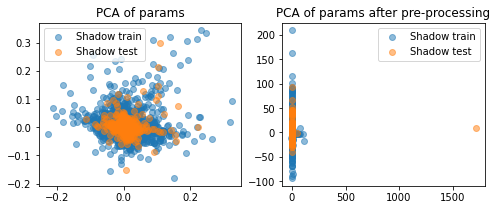

In [6]:
# PCA on shadow model params
pca = decomposition.PCA(n_components=2)
pca.fit(np.concatenate([shadow_train_params, shadow_eval_params]))
shadow_train_params_pca = pca.transform(shadow_train_params)
shadow_eval_params_pca = pca.transform(shadow_eval_params)

# PCA on rescaled shadow model params
pca = decomposition.PCA(n_components=2)
pca.fit(
    np.concatenate([shadow_train_rescaled_params, shadow_eval_rescaled_params]))
shadow_train_params_scaled_pca = pca.transform(shadow_train_rescaled_params)
shadow_eval_params_scaled_pca = pca.transform(shadow_eval_rescaled_params)

# Plot PCA
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(8,3))
ax1.scatter(
    shadow_train_params_pca[:, 0],
    shadow_train_params_pca[:, 1],
    label='Shadow train',
    alpha=.5)
ax1.scatter(
    shadow_eval_params_pca[:, 0],
    shadow_eval_params_pca[:, 1],
    label='Shadow test',
    alpha=.5)
ax1.set_title('PCA of params')
ax1.legend(loc='best')

ax2.scatter(
    shadow_train_params_scaled_pca[:, 0],
    shadow_train_params_scaled_pca[:, 1],
    label='Shadow train',
    alpha=.5)
ax2.scatter(
    shadow_eval_params_scaled_pca[:, 0],
    shadow_eval_params_scaled_pca[:, 1],
    label='Shadow test',
    alpha=.5)
ax2.set_title('PCA of params after pre-processing')
ax2.legend(loc='best')

# Create new training and eval dataset for reconstruction task.
reconstruction_train_data = ReconstructionDataset(
    params=shadow_train_rescaled_params, images=shadow_train_data.images)
reconstruction_eval_data = ReconstructionDataset(
    params=shadow_eval_rescaled_params, images=shadow_eval_data.images)

In [7]:
reconstructor_training_epochs = 200  #@param {type:"integer"}
reconstructor_lr = 3e-4  #@param {type:"number"}


def reconstructor_network_forward(params):
  """Reconstructor network architecture."""
  net = hk.nets.MLP([1000, 1000, 784],
                    activation=jax.nn.relu,
                    activate_final=False)
  return net(params)


# Set-up reconstructor network and optimizer.
reconstructor_network = hk.without_apply_rng(
    hk.transform(reconstructor_network_forward))
opt_init, opt_update = optax.rmsprop(reconstructor_lr)


@jax.jit
def mse_loss(reconstructor_params, params_batch, images_batch):
  """MSE loss between reconstruction and target."""
  batch_size = params_batch.shape[0]
  images_batch_logits = reconstructor_network.apply(reconstructor_params,
                                                  params_batch)
  images_batch_pred = jax.nn.sigmoid(images_batch_logits)
  return jnp.mean(jnp.mean((images_batch_pred - images_batch)**2, axis=1))


@jax.jit
def mae_loss(reconstructor_params, params_batch, images_batch):
  """MAE loss between reconstruction and target."""
  batch_size = params_batch.shape[0]
  images_batch_logits = reconstructor_network.apply(reconstructor_params,
                                                  params_batch)
  images_batch_pred = jax.nn.sigmoid(images_batch_logits)
  return jnp.mean(jnp.mean(jnp.abs(images_batch_pred - images_batch), axis=1))


@jax.jit
def mse_and_mae_loss(reconstructor_params, params_batch, images_batch):
  """MSE and MAE loss between reconstruction and target."""
  mae = mae_loss(reconstructor_params, params_batch, images_batch)
  mse = mse_loss(reconstructor_params, params_batch, images_batch)
  return mae + mse, (mae, mse)


@jax.jit
def reconstructor_network_update(reconstructor_params, opt_state, params_batch,
                                 images_batch):
  (loss, (_, _)), gradient = jax.value_and_grad(
      mse_and_mae_loss, has_aux=True)(reconstructor_params, params_batch,
                                      images_batch)
  updates, opt_state = opt_update(gradient, opt_state)
  new_reconstructor_params = optax.apply_updates(reconstructor_params, updates)
  return new_reconstructor_params, opt_state, loss


def reconstructor_network_train(step_fn, params_train, images_train,
                                params_test, images_test, num_splits,
                                num_epochs):
  rng = jax.random.PRNGKey(42)
  param = jnp.ones([1, params_train.shape[1]])
  reconstructor_params = reconstructor_network.init(rng, param)
  opt_state = opt_init(reconstructor_params)
  print('Epoch\tBatch\tTrain_loss\tTest_loss\tTest_mae\tTest_mse')
  for epoch in range(num_epochs):
    params_train, images_train = utils.shuffle(params_train, images_train)
    batched_idxs = np.array_split(
        np.arange(len(params_train)),
        len(params_train) // num_splits)
    for i, idxs in enumerate(batched_idxs):
      reconstructor_params, opt_state, train_loss = step_fn(
          reconstructor_params, opt_state, params_train[idxs],
          images_train[idxs])
      if i % 1000 == 0 and epoch % 10 == 0:
        test_loss, (test_mae,
                    test_mse) = mse_and_mae_loss(reconstructor_params,
                                                 params_test, images_test)
        print((f'{epoch}/{num_epochs}\t{i}/{len(batched_idxs)}\t'
               f'{train_loss:>8.4f}\t{test_loss:>8.4f}\t{test_mae:>8.4f}\t'
               f'{test_mse:>8.4f}'))
  return reconstructor_params


# Train reconstructor network for 'reconstructor_training_epochs' epochs.
opt_reconstructor_params = reconstructor_network_train(
    step_fn=reconstructor_network_update,
    params_train=reconstruction_train_data.params,
    images_train=reconstruction_train_data.images,
    params_test=reconstruction_eval_data.params,
    images_test=reconstruction_eval_data.images,
    num_splits=32,
    num_epochs=reconstructor_training_epochs,
)
print('Done')

Epoch	Batch	Train_loss	Test_loss	Test_mae	Test_mse
0/200	0/312	  0.7026	  0.6910	  0.4639	  0.2271
10/200	0/312	  0.0542	  0.0817	  0.0535	  0.0282
20/200	0/312	  0.0365	  0.0707	  0.0463	  0.0244
30/200	0/312	  0.0379	  0.0665	  0.0437	  0.0228
40/200	0/312	  0.0255	  0.0643	  0.0422	  0.0221
50/200	0/312	  0.0294	  0.0635	  0.0417	  0.0218
60/200	0/312	  0.0313	  0.0627	  0.0412	  0.0215
70/200	0/312	  0.0260	  0.0618	  0.0407	  0.0211
80/200	0/312	  0.0257	  0.0614	  0.0405	  0.0209
90/200	0/312	  0.0228	  0.0610	  0.0402	  0.0207
100/200	0/312	  0.0223	  0.0606	  0.0401	  0.0205
110/200	0/312	  0.0224	  0.0604	  0.0399	  0.0204
120/200	0/312	  0.0215	  0.0599	  0.0397	  0.0202
130/200	0/312	  0.0223	  0.0596	  0.0396	  0.0201
140/200	0/312	  0.0214	  0.0594	  0.0394	  0.0199
150/200	0/312	  0.0192	  0.0591	  0.0393	  0.0198
160/200	0/312	  0.0157	  0.0588	  0.0392	  0.0196
170/200	0/312	  0.0157	  0.0586	  0.0390	  0.0195
180/200	0/312	  0.0173	  0.0584	  0.0390	  0.0195
190/200	0/

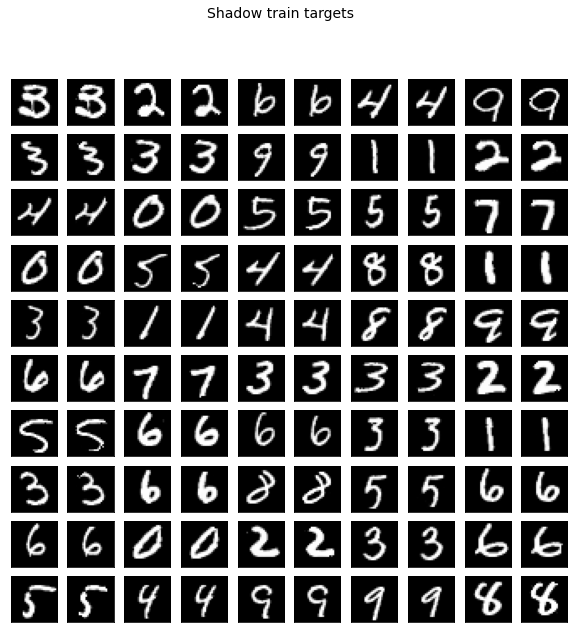

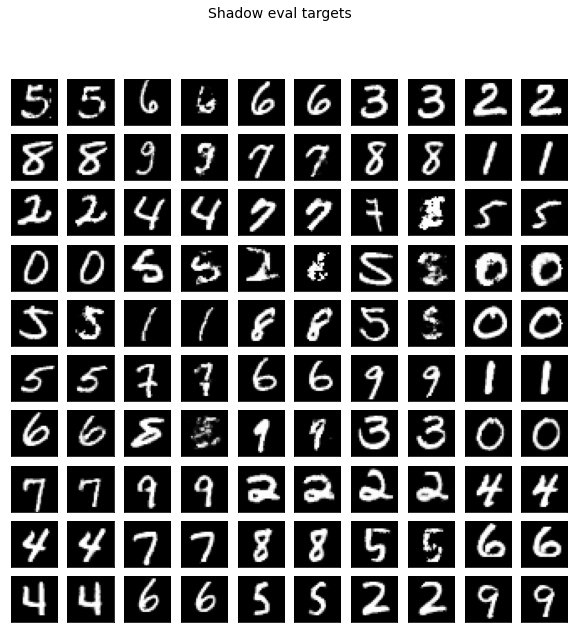

In [8]:
batch_size = 50  #@param {type:"slider", min:1, max:50, step:1}


# Helper function to display digit images
def show_sample(images, sample_count=25, is_train=False):
  # Create a square with can fit {sample_count} images.
  grid_count = math.ceil(math.ceil(math.sqrt(sample_count)))
  grid_count = min(grid_count, len(images))
  plt.figure(figsize=(grid_count, grid_count))
  for i in range(sample_count):
    plt.subplot(grid_count, grid_count, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap=plt.cm.gray, vmin=0, vmax=1.)
  plt.suptitle(
      'Shadow train targets' if is_train else 'Shadow eval targets',
      fontsize=14)


images_train_logits = reconstructor_network.apply(
    opt_reconstructor_params, reconstruction_train_data.params[:batch_size])
images_train_pred = jax.nn.sigmoid(images_train_logits)
images_train_target = reconstruction_train_data.images[:batch_size]
images_to_plot = np.empty(
    (images_train_target.shape[0] + images_train_pred.shape[0],
     images_train_target.shape[1]))
images_to_plot[::2, :] = images_train_target
images_to_plot[1::2, :] = images_train_pred
images_to_plot = images_to_plot.reshape((images_to_plot.shape[0], 28, 28))
show_sample(images_to_plot, sample_count=images_to_plot.shape[0], is_train=True)

images_test_logits = reconstructor_network.apply(
    opt_reconstructor_params, reconstruction_eval_data.params[:batch_size])
images_test_pred = jax.nn.sigmoid(images_test_logits)
images_test_target = reconstruction_eval_data.images[:batch_size]
images_to_plot = np.empty(
    (images_test_target.shape[0] + images_test_pred.shape[0],
     images_test_target.shape[1]))
images_to_plot[::2, :] = images_test_target
images_to_plot[1::2, :] = images_test_pred
images_to_plot = images_to_plot.reshape((images_to_plot.shape[0], 28, 28))
show_sample(
    images_to_plot, sample_count=images_to_plot.shape[0], is_train=False)